<a href="https://colab.research.google.com/github/st-sashou/ai_experimental/blob/master/feature_importance_reverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ランダムフォレストによる特徴量の重要度の算出
説明変数を**Axxx～Bxxx**、目的変数を**年収**とする。  
年収に与える各説明変数の影響度を算出することとする。

## アンケートデータの読み込み

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/ST/アンケート重要度/cw_5th_12000_survey.pkl'
df_survey = pd.read_pickle(INPUT_FILE)
df_survey = df_survey.loc[:, ['survey_number', 'question']].set_index('survey_number')
df_survey.head()

,question
survey_number,
P001,月間の労働時間は１６０時間を超えていますか？
P002,あなたの生まれた年を教えてください
P003,あなたの性別を教えてください
P004,あなたの身長を教えてください
P005,あなたの体重を教えてください


In [3]:
INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/ST/アンケート重要度/cw_5th_12000_answer.pkl'
df = pd.read_pickle(INPUT_FILE)
df.head()

,respondent_id,annual_income,A002,A003,A004,A005,A006,A008,A009,A010,...,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010
0,399534,550,False,True,False,False,False,True,True,False,...,True,1976,"""男性""",175,64.0,40,70,0,"""事務""","""係長・主任"""
1,488842,120,True,True,True,False,True,True,True,False,...,True,1980,"""男性""",177,64.4,10,0,0,"""サービス""","""その他専門職・特別職等"""
2,515662,260,False,False,False,True,False,False,False,False,...,True,1983,"""女性""",156,48.0,20,20,0,"""営業・販売""","""係長・主任"""
3,890958,96,True,False,True,False,True,False,True,False,...,True,1974,"""女性""",158,72.6,8,0,0,"""その他""","""その他専門職・特別職等"""
4,1227044,292,True,False,True,False,True,True,True,False,...,True,1986,"""女性""",157,49.0,21,40,0,"""その他""","""一般社員"""


## 事前処理

In [0]:
columns = df.columns
columns = pd.Series(columns[columns.str.startswith('A') | columns.str.startswith('B')].sort_values(ascending=True))

X = df.loc[:, columns].astype('float')
Y = df.loc[:, ['annual_income']]

In [0]:
X.loc[:, columns.str.startswith('B').values] *= -1
X.loc[:, columns.str.startswith('B').values] += 1

In [6]:
X.head()

,A002,A003,A004,A005,A006,A008,A009,A010,A011,A013,...,B704,B705,B706,B707,B708,B709,B710,B711,B712,B713
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
Y.head()

,annual_income
0,550
1,120
2,260
3,96
4,292


## ランダムフォレストオブジェクトによる重要度の抽出

### オブジェクトの生成とモデルの適合

In [8]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500, random_state=1)
forest.fit(X, Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

### 重要度の表示



*   number: アンケート番号
*   importance: 重要度 (0≦importance≦1)
*   question: アンケート文



In [9]:
import numpy as np

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("   %-*s %-*s %s" % (8, 'number', 12, 'importance', 'question'))
for f in range(X.shape[1]):
    print("%2d) %-*s %-*f %s" %
            (f + 1, 8, columns[indices[f]], 10, importances[indices[f]], df_survey.at[columns[indices[f]], 'question']))

   number   importance   question
 1) B649     0.043273   直近１ヶ月間は、熱が出やすかったですか？
 2) B627     0.032078   直近１ヶ月間で、アトピー性皮膚炎の症状がありましたか？
 3) A180     0.031846   週に１回以上、春菊を食べていますか？
 4) A730     0.031746   マヨネーズを、手作りしていますか？
 5) A143     0.025657   週に１回以上、ドラゴンフルーツ（ピタヤ）を食べていますか？
 6) A773     0.022632   眠りにつく１時間前は、テレビを見ないようにしていますか？
 7) B524     0.019883   直近１ヶ月間で、指で押すと、へこみの残るようなむくみはありましたか？
 8) B632     0.016984   直近１ヶ月間が花粉のシーズンの場合、肌が荒れたことはありましたか？
 9) A695     0.015325   １日に１リットル以上の水または白湯（さゆ）を飲むようにしていますか？
10) A294     0.014356   換気をするようにしていますか？
11) A150     0.014277   週に１回以上、パイナップルを食べていますか？
12) A637     0.013233   月に１回以上、根菜や野菜を食べていますか？
13) B443     0.013111   月に１回以上、アレルギー症状のために、仕事や家事を休んだことがありますか？
14) A072     0.011795   夜の１２時までに就寝していますか？
15) A729     0.010787   ドレッシングを、手作りしていますか？
16) A522     0.010517   月に１回以上、もやしを食べていますか？
17) B267     0.010423   人よりも白髪が多いですか？
18) A116     0.010350   週に１回以上、きのこ類を食べていますか？
19) A130     0.009633   週に１回以上、シジミを食べていますか？
20) A540     0.009116   月に１回以上、豆腐を食べていますか？
21) B66

### 上位100問までの重要度のグラフ

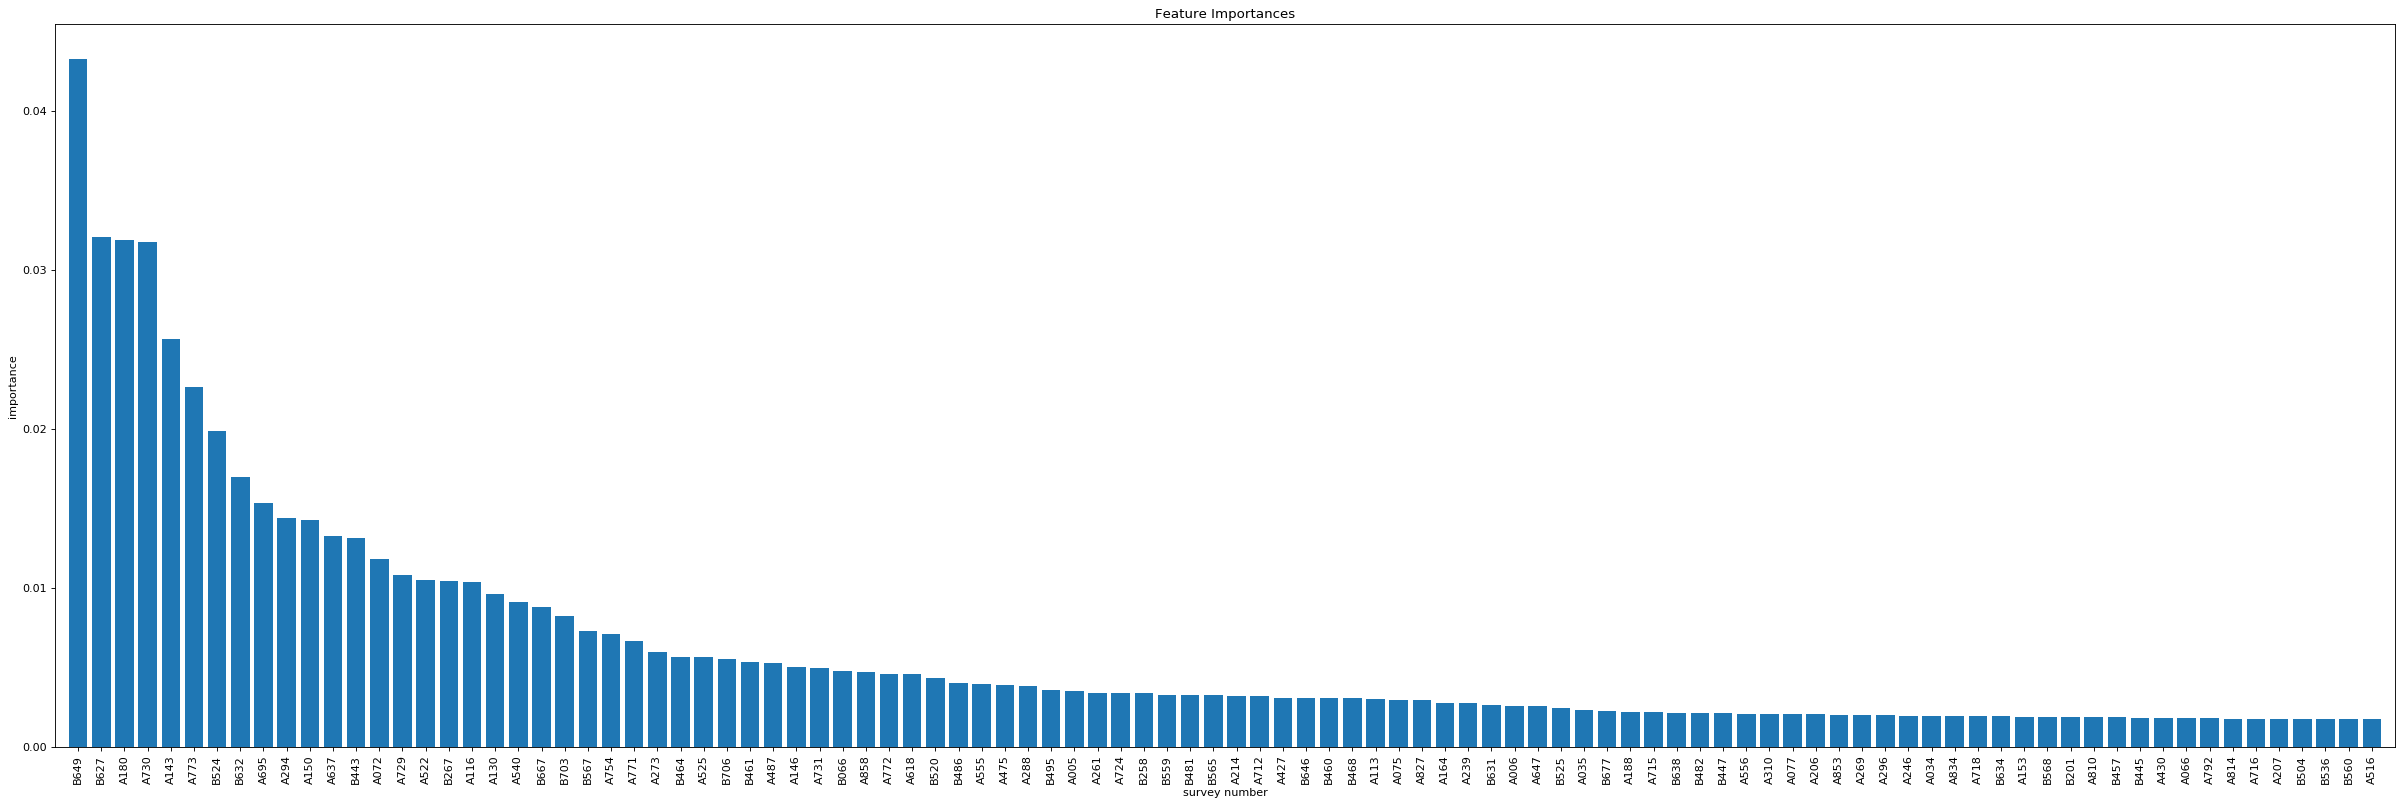

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10), dpi=80)
plt.title('Feature Importances')
plt.bar(range(100), importances[indices[0:100]], align='center')
plt.xticks(range(100), columns[indices[0:100]], rotation=90)
plt.xlim([-1, 100])
plt.tight_layout()
plt.xlabel('survey number')
plt.ylabel('importance')
plt.show()